# Spectra

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
for x in amrwindfedirs: sys.path.insert(1, x+'/utilities')    

import postproamrwindsample_xarray as ppsamplexr
import windspectra

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os.path
import re
from matplotlib.lines import Line2D

import amrwind_frontend  as amrwind

%matplotlib inline

In [2]:
amrdir = '/gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03-at/post_processing'
ncfile = 'sampling_80000.nc'  # netcdf filename
ablstats = 'abl_statistics80000.nc'

In [5]:
def avgSpectraNCfile(ncfilename, ptlist, group, timeindices, avgbins=[], verbose=True):
    # Initialize dicts
    Suu_avg=None
    Svv_avg=None
    Sww_avg=None
    avgUlong=None
    all_ulongavgs = []
    # First extract all of the data from the netcdf file
    db = ppsamplexr.getPlanePtsXR(ncfilename, timeindices, ptlist, groupname=group, verbose=verbose, gettimes=True)
    t  = np.array(db['times'])
    for ipt, pt in enumerate(ptlist):
        u = np.array(db[pt]['velocityx'])
        v = np.array(db[pt]['velocityy'])
        w = np.array(db[pt]['velocityz'])
        ulong, ulat = windspectra.convertUxytoLongLat(u,v)
        all_ulongavgs.append(np.mean(ulong))
        f, Suu      = windspectra.avgWindSpectra(t, ulong, avgbins)
        f, Svv      = windspectra.avgWindSpectra(t, ulat,  avgbins)
        f, Sww      = windspectra.avgWindSpectra(t, w,     avgbins)        
        if ipt == 0:
            lent    = len(t)
            favg    = f
            Suu_avg = Suu
            Svv_avg = Svv
            Sww_avg = Sww
        else:
            Suu_avg = Suu_avg + Suu
            Svv_avg = Svv_avg + Svv
            Sww_avg = Sww_avg + Sww    
    Npts = len(ptlist)
    Suu_avg = Suu_avg/Npts
    Svv_avg = Svv_avg/Npts
    Sww_avg = Sww_avg/Npts
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs)


In [6]:
ipts = [0, 10, 20, 30, 40, 50]
jpts = [0, 10, 20, 30, 40, 50]
kpt  = 0
ptlist = []
for i in ipts:
    for j in jpts:
        ptlist.append((kpt, j, i))
        
timeindices=list(range(20000))[::10]
group='p_hub'

In [7]:
favg, Suu_avg, Svv_avg, Sww_avg, avgUlong = avgSpectraNCfile(amrdir+'/'+ncfile, ptlist, group, timeindices, avgbins=[], verbose=True)

## Load Kaimal data

In [8]:
case = amrwind.MyApp.init_nogui()

In [9]:
case.ABLpostpro_loadnetcdffile(amrdir+'/'+ablstats)

Loading /gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03-at/post_processing/abl_statistics80000.nc
Time range: 20000.250000 to 25000.000000
Done.


In [10]:
ablreport=case.ABLpostpro_printreport(avgt=[20000, 25000], avgz=[90])

Loading w'w'_r
Loading theta
Loading v'v'_r
Loading u
Loading u'u'_r
Loading w'theta'_r
Loading v
Rotor span not specified. Fitting alpha over entire vertical domain
Rotor span not specified. Fitting veer over entire vertical domain
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    90.00 6.264782e+00 2.700006e+02 6.261624e-02 9.739703e-02 1.121706e-01 1.608985e-01 3.865131e+04 1.855527e-02 2.107706e-02 

ustar: 0.289809


In [11]:
utau   = ablreport['ustar'] #0.289809
Suu_Kai = windspectra.getKaimal(favg, 90.0, avgUlong)
Svv_Kai = windspectra.getKaimal(favg, 90.0, avgUlong, params=windspectra.vKaimalconst)
Sww_Kai = windspectra.getKaimal(favg, 90.0, avgUlong, params=windspectra.wKaimalconst)

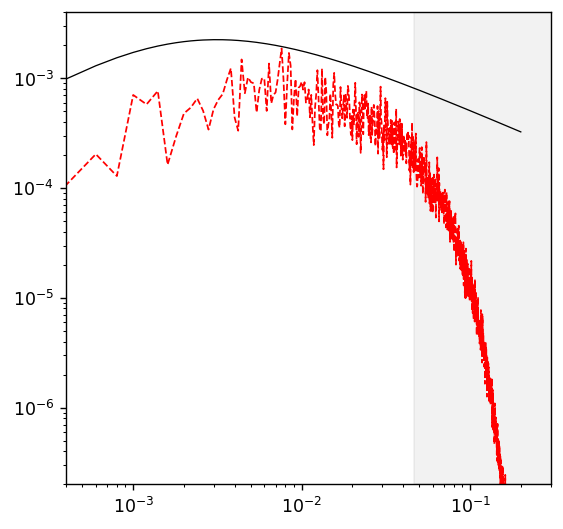

In [18]:
nband=3
U = avgUlong
f, Suu = windspectra.NarrowToOctaveBand(favg, Suu_avg, nband)

plt.figure(figsize=(5,5), dpi=125)
plt.loglog(favg, favg*Suu_avg/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
#plt.loglog(f, f*Suu/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
plt.loglog(favg, utau**2*Suu_Kai/avgUlong**2, '-', color='k', lw=0.75, label='Kaimal')
plt.ylim([2E-7, 4E-3]);
plt.xlim([4E-4, 0.3]);

dx=10
fmax=0.6*U/(8.0*dx)
plt.axvspan(fmax, 10, alpha=0.1, color='gray')

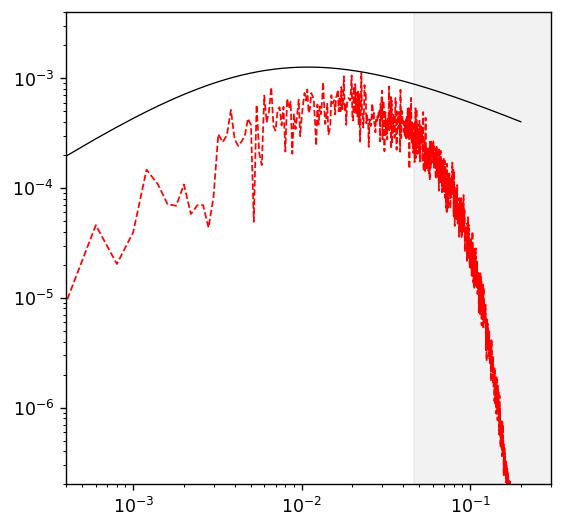

In [19]:
plt.figure(figsize=(5,5), dpi=125)
plt.loglog(favg, favg*Svv_avg/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
#plt.loglog(f, f*Suu/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
plt.loglog(favg, utau**2*Svv_Kai/avgUlong**2, '-', color='k', lw=0.75, label='Kaimal')
plt.ylim([2E-7, 4E-3]);

plt.xlim([4E-4, 0.3]);

dx=10
fmax=0.6*U/(8.0*dx)
plt.axvspan(fmax, 10, alpha=0.1, color='gray')

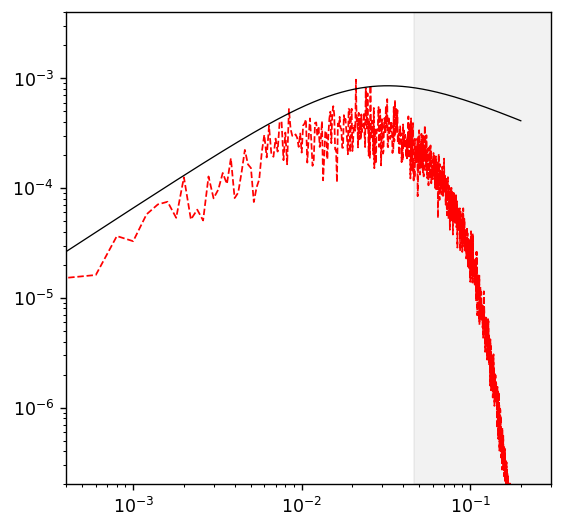

In [20]:
plt.figure(figsize=(5,5), dpi=125)
plt.loglog(favg, favg*Sww_avg/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
#plt.loglog(f, f*Suu/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
plt.loglog(favg, utau**2*Sww_Kai/avgUlong**2, '-', color='k', lw=0.75, label='Kaimal')
plt.ylim([2E-7, 4E-3]);

plt.xlim([4E-4, 0.3]);

dx=10
fmax=0.6*U/(8.0*dx)
plt.axvspan(fmax, 10, alpha=0.1, color='gray')